In [53]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [54]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv('data/train.csv')
df = pd.read_csv('training_data_with_weather_info_week_3.csv')

df['Date'] = pd.to_datetime( df['Date']) # Convert date into datetime format
df.head(4)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,temp,min,max,stp,slp,dewp,wdsp,prcp,fog
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan-,33.0,65.0,22,42.6,33.6,54.9,999.9,1024.3,27.4,9.4,0.00,0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan-,33.0,65.0,23,42.0,32.7,55.9,999.9,1020.8,22.8,14.9,99.99,1
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,Afghanistan-,33.0,65.0,24,40.1,36.9,43.2,999.9,1018.6,34.5,10.4,0.17,1
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,Afghanistan-,33.0,65.0,25,46.0,37.9,56.3,999.9,1018.0,37.8,6.1,0.57,1


In [56]:
# # Use data only if confirmed cases are non-zero 
## * IN process
# bool_flag = df['ConfirmedCases'] > 0.0

# df = df[bool_flag]

# df.head(5)

In [57]:
# Note this works because for each country and province the date column is starting from the same day.
df['Num_Days'] = ( df['Date'] - df['Date'][0] ).dt.days # Add a coulmn for number of days from the first reported case.

In [61]:
#--- Some info about the data set.
df.info()
df.columns
df.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22338 entries, 0 to 22337
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  22338 non-null  int64         
 1   Province_State      22338 non-null  object        
 2   Country_Region      22338 non-null  object        
 3   Date                22338 non-null  datetime64[ns]
 4   ConfirmedCases      22338 non-null  float64       
 5   Fatalities          22338 non-null  float64       
 6   country+province    22338 non-null  object        
 7   Lat                 22338 non-null  float64       
 8   Long                22338 non-null  float64       
 9   day_from_jan_first  22338 non-null  int64         
 10  temp                22338 non-null  float64       
 11  min                 22219 non-null  float64       
 12  max                 22309 non-null  float64       
 13  stp                 22338 non-null  float64   

RangeIndex(start=0, stop=22338, step=1)

In [62]:
#--- Check how many NAN are there.
for i in df.columns:
    print( "NAN count:", i, ',', sum( df[i].isna() )  )
#     print( "\n", [sum( df[i].isna() ) for i in df.columns])

# Fill not-known data 
# df = df.fillna( 'NoInfo')
df = df.fillna( {'Province_State':'NoInfo'} )

NAN count: Id , 0
NAN count: Province_State , 0
NAN count: Country_Region , 0
NAN count: Date , 0
NAN count: ConfirmedCases , 0
NAN count: Fatalities , 0
NAN count: country+province , 0
NAN count: Lat , 0
NAN count: Long , 0
NAN count: day_from_jan_first , 0
NAN count: temp , 0
NAN count: min , 119
NAN count: max , 29
NAN count: stp , 0
NAN count: slp , 9002
NAN count: dewp , 598
NAN count: wdsp , 0
NAN count: prcp , 0
NAN count: fog , 0
NAN count: Num_Days , 0


In [63]:
df['Province_State'].unique()
# df['Country_Region'].unique()

array(['NoInfo', 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
       'Northwest Territories', 'Nova Scotia', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon', 'Anhui',
       'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi',
       'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hong Kong',
       'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin',
       'Liaoning', 'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong',
       'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang',
       'Yunnan', 'Zhejiang', 'Faroe Islands', 'Greenland',
       'French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'St Martin', 'Aru

In [64]:
# To get the country names and province names 
def search_country_province( country, province, df):
    # Search country
    out = []
    for CName in df['Country_Region'].unique():
        if re.search(country, CName):
            out.append(CName)
    print('Countries: ', out)
    # Search province
    out = []
    for PName in df['Province_State'].unique():
        if re.search(province, PName):
               out.append(PName)
    print('Province: ', out)

search_country_province( 'U', 'North', df)

Countries:  ['US', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uruguay', 'Uzbekistan']
Province:  ['Northern Territory', 'Northwest Territories', 'North Carolina', 'North Dakota']


In [65]:
def df_country_province( df, CName, PName ):
    '''
    * Data for a given country and provice.
    * Note, output df has multilevel indexes.
    '''
    out = df.set_index( ['Country_Region', 'Province_State'] )
    out.head()
     
    return out.loc[(CName,PName)]
    
# Extract US data summed over all provices/states
df_r = df_country_province(df, 'US', 'Alabama')
df_r.head(5)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


Id       Date  ConfirmedCases  Fatalities  \
Country_Region Province_State                                                 
US             Alabama         24825 2020-01-22             0.0         0.0   
               Alabama         24826 2020-01-23             0.0         0.0   
               Alabama         24827 2020-01-24             0.0         0.0   
               Alabama         24828 2020-01-25             0.0         0.0   
               Alabama         24829 2020-01-26             0.0         0.0   

                              country+province      Lat     Long  \
Country_Region Province_State                                      
US             Alabama              US-Alabama  32.3182 -86.9023   
               Alabama              US-Alabama  32.3182 -86.9023   
               Alabama              US-Alabama  32.3182 -86.9023   
               Alabama              US-Alabama  32.3182 -86.9023   
               Alabama              US-Alabama  32.3182 -86.9023   

                               day_from_jan_first  temp   min   max    stp  \
Country_Region Province_State                                                
US             Alabama                         22  33.7  21.6  48.9  999.9   
               Alabama                         23  41.5  37.9  46.2  999.9   
               Alabama                         24  51.6  45.9  61.0  999.9   
               Alabama                         25  43.1  29.5  57.0  999.9   
               Alabama                         26  42.5  31.6  53.8  999.9   

                               slp  dewp  wdsp  prcp  fog  Num_Days  
Country_Region Province_State                                        
US             Alabama         NaN   NaN   2.5  0.00    0         0  
               Alabama         NaN   NaN   2.8  0.00    0         1  
               Alabama         NaN   NaN   4.9  0.87    0         2  
               Alabama         NaN   NaN   5.4  0.02    0         3  
               Alabama         NaN   NaN   2.0  0.00    0         4

In [66]:
def df_summed_provinces( df, CName ):
    '''
    * Sum over provices for a given country.
    * Note, output df has multilevel indexes.
    '''
    out = df.groupby( [ 'Country_Region','Num_Days']).sum()
    
    # Make hierarchical labels
    # df_r = df.groupby( ['Country_Region', 'Province_State'] )
    #df_r = df.set_index( ['Country_Region', 'Province_State'] )
    
    return out.loc[(CName,)]

# Extract US data summed over all provices/states
df_r = df_summed_provinces(df, 'United Kingdom')
df_r

,Id,ConfirmedCases,Fatalities,Lat,Long,day_from_jan_first,temp,min,max,stp,slp,dewp,wdsp,prcp,fog
Num_Days,,,,,,,,,,,,,,,
0,314055,0.0,0.0,321.820555,-423.818056,220,616.6,570.2,649.5,5110.8,5141.7,558.3,73.7,300.19,5
1,314065,0.0,0.0,321.820555,-423.818056,230,630.3,596.9,658.8,5093.5,5124.6,562.5,68.7,200.45,4
2,314075,0.0,0.0,321.820555,-423.818056,240,631.9,591.4,659.8,6055.0,4085.7,579.6,53.8,200.63,4
3,314085,0.0,0.0,321.820555,-423.818056,250,634.1,591.2,659.8,6041.5,4072.2,574.1,54.9,100.31,3
4,314095,0.0,0.0,321.820555,-423.818056,260,639.4,589.0,680.9,6021.7,5068.0,589.8,60.5,200.55,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,314735,22453.0,1411.0,321.820555,-423.818056,900,635.2,602.2,670.0,5116.9,5148.1,535.3,100.4,0.07,1
69,314745,25481.0,1793.0,321.820555,-423.818056,910,637.1,605.8,668.2,5116.9,5148.1,538.9,104.3,0.07,1
70,314755,29865.0,2357.0,321.820555,-423.818056,920,637.1,605.8,668.2,5116.9,5148.1,538.9,104.3,0.07,1


# Plots

## Compare two provinces

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


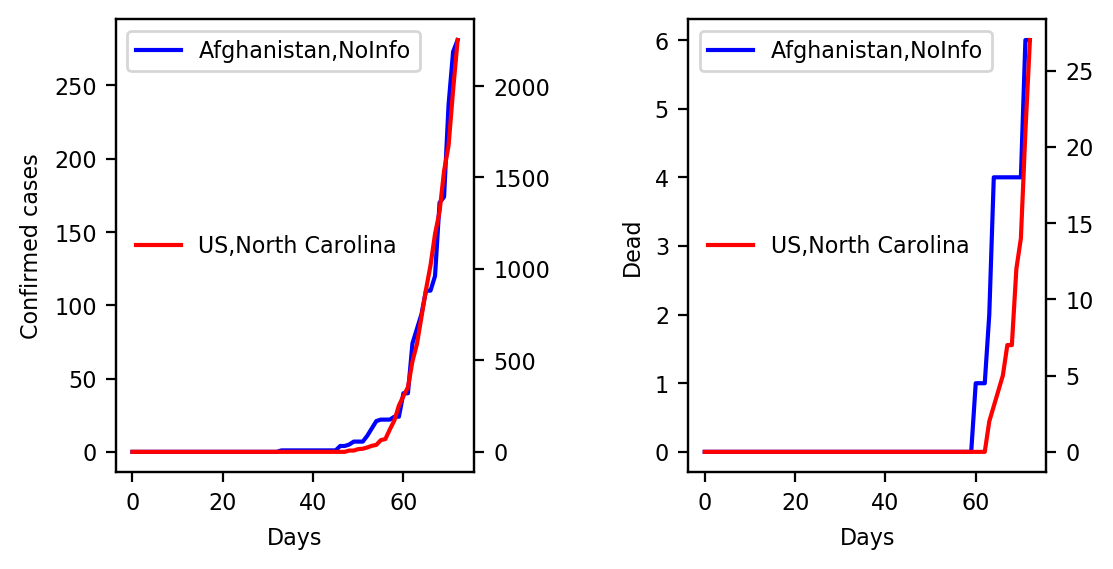

In [67]:
CName = 'Afghanistan'
PName = 'NoInfo'
# PName = 'North Carolina'

df_p = df_country_province(df, CName, PName)

fig, ax = plt.subplots(1,2, figsize = (6,3), dpi=200)
# fig, ax = plt.subplots(1,2, dpi=200)
fig.subplots_adjust(wspace=0.6, hspace=0.0)
ax = ax.ravel()
fontl=8

ax[0].plot( df_p['Num_Days'], df_p['ConfirmedCases'],'-',color='b', label=CName+','+PName)
ax[1].plot( df_p['Num_Days'], df_p['Fatalities'],'-',color='b', label=CName+','+PName)

# Second country, y2 axis
CName = 'US'
PName = 'North Carolina'
df_p = df_country_province(df, CName, PName)

axY2 = [ax[0].twinx(), ax[1].twinx()]
axY2[0].plot( df_p['Num_Days'], df_p['ConfirmedCases'],'-',color='r', label=CName+','+PName)
axY2[1].plot( df_p['Num_Days'], df_p['Fatalities'],'-',color='r', label=CName+','+PName)

for iPlot in [0,1]:
    ax[iPlot].set_xlabel('Days', fontsize=fontl)
#     ax[0].set_title( 'Cases', fontsize=fontl)
#     ax[1].set_title( 'Dead', fontsize=fontl)
    
    ax[0].set_ylabel('Confirmed cases', fontsize=fontl)
    ax[1].set_ylabel('Dead', fontsize=fontl)
    
    ax[iPlot].legend( loc='upper left', frameon = 0, fontsize=fontl)
    ax[iPlot].tick_params(axis='both', which='major', labelsize=1.0*fontl)
    
    axY2[iPlot].legend( loc='center left', frameon = 0, fontsize=fontl)
    axY2[iPlot].tick_params(axis='both', which='major', labelsize=1.0*fontl)
    
    ax[iPlot].legend( loc='upper left', frameon = 'True', fontsize=fontl)

In [68]:
search_country_province( 'Ind', 'No', df)

Countries:  ['India', 'Indonesia']
Province:  ['NoInfo', 'Northern Territory', 'Northwest Territories', 'Nova Scotia', 'North Carolina', 'North Dakota']


## Compare two countries

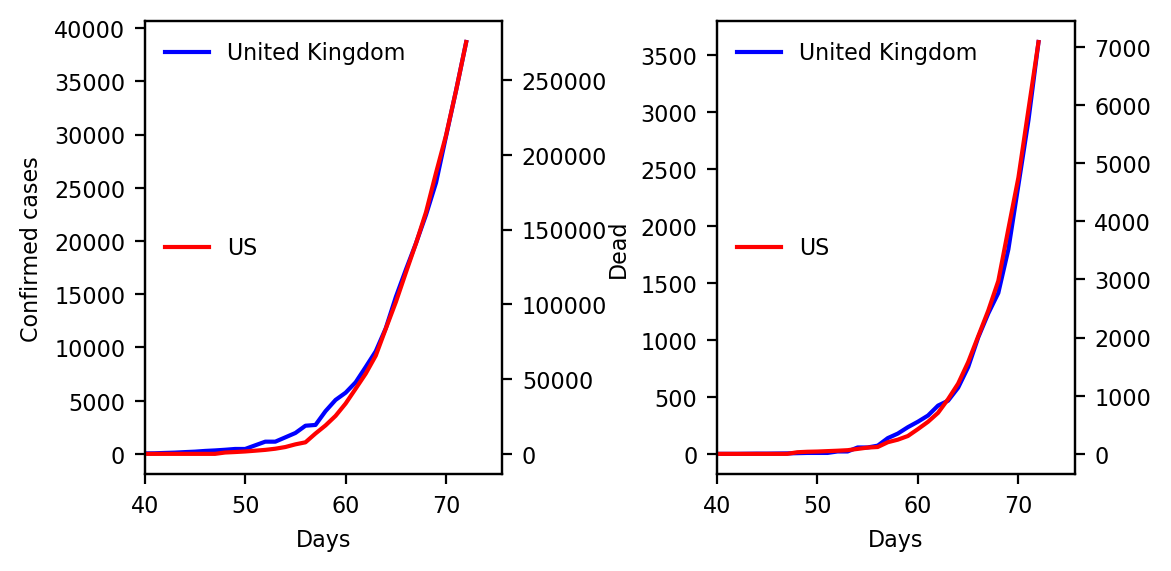

In [69]:
CName = 'United Kingdom'

df_p = df_summed_provinces(df, CName)

fig, ax = plt.subplots(1,2, figsize = (6,3), dpi=200)
# fig, ax = plt.subplots(1,2, dpi=200)
fig.subplots_adjust(wspace=0.6, hspace=0.0)
ax = ax.ravel()
fontl=8

ax[0].plot( df_p.index, df_p['ConfirmedCases'],'-',color='b', label=CName)
ax[1].plot( df_p.index, df_p['Fatalities'],'-',color='b', label=CName)

# Second country, y2 axis
CName = 'US'
df_p = df_summed_provinces(df, CName)

axY2 = [ax[0].twinx(), ax[1].twinx()]
axY2[0].plot( df_p.index, df_p['ConfirmedCases'],'-',color='r', label=CName)
axY2[1].plot( df_p.index, df_p['Fatalities'],'-',color='r', label=CName)

for iPlot in [0,1]:
    ax[iPlot].set_xlabel('Days', fontsize=fontl)
#     ax[0].set_title( 'Cases', fontsize=fontl)
#     ax[1].set_title( 'Dead', fontsize=fontl)
    
    ax[0].set_ylabel('Confirmed cases', fontsize=fontl)
    ax[1].set_ylabel('Dead', fontsize=fontl)
    
    ax[iPlot].legend( loc='upper left', frameon = 0, fontsize=fontl)
    ax[iPlot].tick_params(axis='both', which='major', labelsize=1.0*fontl)
    
    axY2[iPlot].legend( loc='center left', frameon = 0, fontsize=fontl)
    axY2[iPlot].tick_params(axis='both', which='major', labelsize=1.0*fontl)
    
    ax[iPlot].set_xlim(40,)

## Other columns

In [70]:
#---- Choose a country and provice

CName = 'US'
PName = 'Alabama'

CName = 'India'
PName = 'NoInfo'

bool_flag = (df['Country_Region'] == CName) & (df['Province_State'] == PName)

df_p = df[bool_flag]
df_p.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,temp,min,max,stp,slp,dewp,wdsp,prcp,fog,Num_Days
10147,14874,NoInfo,India,2020-01-22,0.0,0.0,India-,21.0,78.0,22,79.3,63.7,85.6,999.9,1015.8,65.0,1.9,0.0,0,0
10148,14875,NoInfo,India,2020-01-23,0.0,0.0,India-,21.0,78.0,23,80.8,65.1,87.8,999.9,1014.8,65.9,1.9,0.0,0,1
10149,14876,NoInfo,India,2020-01-24,0.0,0.0,India-,21.0,78.0,24,77.4,60.1,84.9,999.9,1015.0,60.6,1.9,0.0,0,2
10150,14877,NoInfo,India,2020-01-25,0.0,0.0,India-,21.0,78.0,25,77.6,59.7,82.4,999.9,1013.1,60.8,1.9,0.0,0,3
10151,14878,NoInfo,India,2020-01-26,0.0,0.0,India-,21.0,78.0,26,76.9,57.2,86.9,999.9,1014.3,51.0,0.7,0.0,0,4


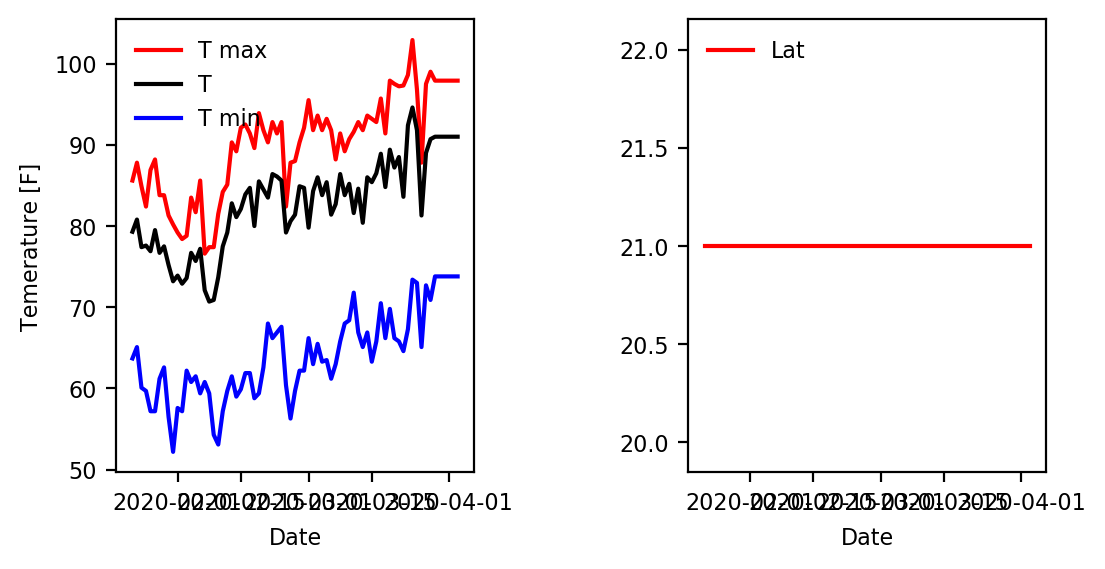

In [71]:
# Plot temperature

fig, ax = plt.subplots(1,2, figsize = (6,3), dpi=200)
# fig, ax = plt.subplots(1,2, dpi=200)
fig.subplots_adjust(wspace=0.6, hspace=0.0)
ax = ax.ravel()
fontl=8

ax[0].plot(df_p['Date'], df_p['max'], '-',color='r', label='T max')
ax[0].plot(df_p['Date'], df_p['temp'], '-',color='k', label='T')
ax[0].plot(df_p['Date'], df_p['min'], '-',color='b', label='T min ')

ax[1].plot(df_p['Date'], df_p['Lat'], '-',color='r', label='Lat')

for iPlot in [0,1]:
    ax[iPlot].set_xlabel('Date', fontsize=fontl)
#     ax[0].set_title( 'Cases', fontsize=fontl)
#     ax[1].set_title( 'Dead', fontsize=fontl)
    
    ax[0].set_ylabel('Temerature [F]', fontsize=fontl)
#     ax[1].set_ylabel('Dead', fontsize=fontl)
    
    ax[iPlot].legend( loc='upper left', frameon = 0, fontsize=fontl)
    ax[iPlot].tick_params(axis='both', which='major', labelsize=1.0*fontl)
    
#     ax[iPlot].set_xlim(40,)

# Learning

## Idea
* Use a country/countries data to train.

In [72]:
def get_ML_dataset( CName, PName, df):

#     bool_flag = (df['Country_Region'] == CName) & (df['Province_State'] == PName)
    bool_flag = (df['Country_Region'] == CName)

    columns_to_keep = ['Fatalities', 'ConfirmedCases', 'Lat', 'Long', 'temp', 'Num_Days'] #, 'min', 'max', 'dewp', 'wdsp', 'prcp', 'fog', 'stp', 'slp']

    df_p = df[bool_flag][columns_to_keep ]
    df_p.head(5)
    # df_p.tail(5)
    
    #---- Make X and y arrays
    X = df_p.iloc[:,1:]
    y = df_p.iloc[:,0]
    
    return X, y

In [73]:
#---- Make a dataset for the learning.
#---- Choose a country and province

CName = 'Italy'
PName = 'Alabama'

X_train, y_train = get_ML_dataset( CName, PName, df)

In [74]:
from sklearn.neighbors import KNeighborsRegressor
knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

# print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'.format(knnreg.score(X_train, y_train)))

R-squared test score: 0.997


# Tests

In [75]:
CName = 'India'
PName = 'NoInfo'

X_test, y_test = get_ML_dataset( CName, PName, df)
print('R-squared test score: {:.3f}'.format(knnreg.score(X_test, y_test)))

R-squared test score: 0.974


No handles with labels found to put in legend.


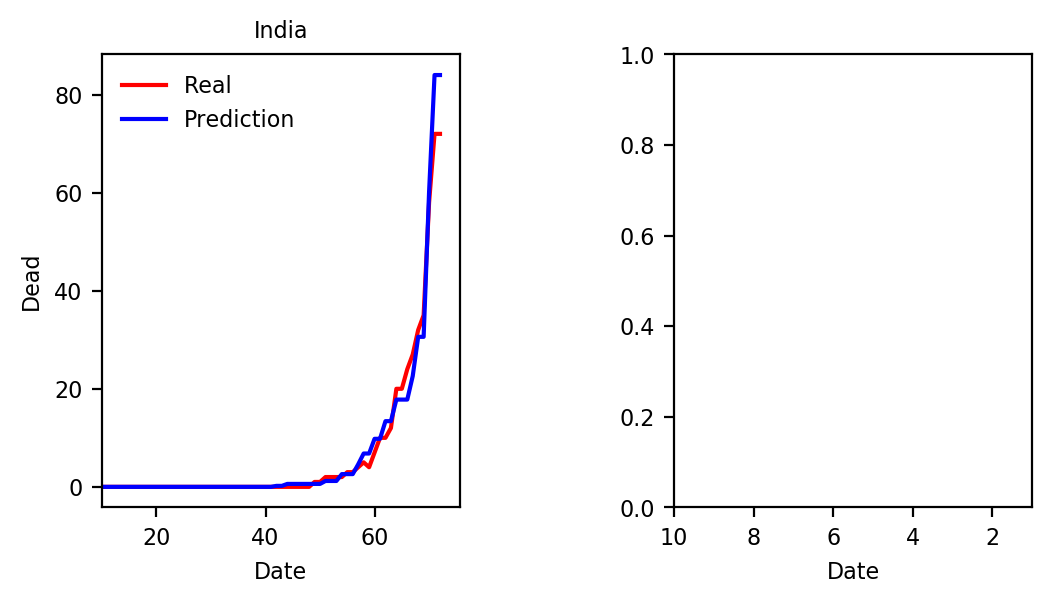

In [76]:
# Plot Predicted values
y_predict = knnreg.predict(X_test)


fig, ax = plt.subplots(1,2, figsize = (6,3), dpi=200)
# fig, ax = plt.subplots(1,2, dpi=200)
fig.subplots_adjust(wspace=0.6, hspace=0.0)
ax = ax.ravel()
fontl=8

ax[0].plot(X_test['Num_Days'], y_test, '-',color='r', label='Real')
ax[0].plot(X_test['Num_Days'], y_predict, '-',color='b', label='Prediction')

for iPlot in [0,1]:
    ax[iPlot].set_xlabel('Date', fontsize=fontl)
    ax[0].set_title( CName, fontsize=fontl)
#     ax[1].set_title( 'Dead', fontsize=fontl)
    
    ax[0].set_ylabel('Dead', fontsize=fontl)
#     ax[1].set_ylabel('Dead', fontsize=fontl)
    
    ax[iPlot].legend( loc='upper left', frameon = 0, fontsize=fontl)
    ax[iPlot].tick_params(axis='both', which='major', labelsize=1.0*fontl)
    
    ax[iPlot].set_xlim(10,)